# Images From Parametric Galaxies

*Synthesizer* can be used to make images of parametric galaxies, by assuming 2D paramertic morphologies for various components.

In the example below we first calculate the photometry (UVJ) from an `Sed` on a galaxy. For further details on an `Sed` see the [Sed docs](../sed/sed.rst) and for galaxies see the [galaxy docs](../galaxy/galaxy.rst).

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18 as cosmo
from unyt import Myr, degree, kpc

from synthesizer.emission_models import IntrinsicEmission
from synthesizer.filters import UVJ
from synthesizer.grid import Grid
from synthesizer.imaging import ImageCollection
from synthesizer.parametric import SFH, Stars, ZDist
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.parametric.morphology import Sersic2D

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

# Set the seed
np.random.seed(42)

# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir, new_lam=np.logspace(2, 5, 600))

# Define the SFH and metallicity distribution
metal_dist = ZDist.DeltaConstant(metallicity=0.01)
sfh_p = {"max_age": 100 * Myr}
sfh = SFH.Constant(**sfh_p)

An important additional object required for parametric imaging is the morphology of the stellar distribution.

Synthesizer provides a number of different parametric morphologies; in this example we use a Sersic profile, defined by the effective radius (`r_eff_kpc` if the image will be in physical cartesian units, or `r_eff_mas` if the image will be in angular coordinates), the Sersic index (`n`), the ellipticity (`ellip`) and the rotation angle (`theta`).

Both the effective radius and rotation angle must be defined with _unyt_ units. The morphology class can convert between cartesian and angular coordinates but only if a cosmology object and redshift of the galaxy is provided.

In [2]:
# Define the morphology using a simple effective radius and slope
morph = Sersic2D(
    r_eff=5 * kpc, sersic_index=1.0, ellipticity=0.4, theta=1 * degree
)

We can then pass the SFH and metallicity distribution functions and morphology model to the `Stars` object to get our stellar component, initialise our galaxy, and generate photometry.

In [3]:
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9.5,
)

# Initialise a parametric Galaxy with a redshift
galaxy = Galaxy(stars, redshift=5)

# Generate stellar spectra
model = IntrinsicEmission(grid, fesc=0.1)
sed = galaxy.stars.get_spectra(model)

# Convert to fluxes
galaxy.get_observed_spectra(cosmo)

# Get a UVJ filter set
filters = UVJ(new_lam=grid.lam)

# Generate stellar photometry
galaxy.stars.spectra["intrinsic"].get_photo_fnu(filters)

## Creating the image

To make an image we first need to define the properties of that image including the resolution and FOV. Note that we could also define the number of pixels instead of the FOV, but one of `fov` or `npix` must be defined, and `resolution` and `fov` must always be given with units.

In [4]:
# Define geometry of the images
fov = 30 * kpc
resolution = fov / 250

print(
    "Image width is %.2f kpc with %.2f kpc resolution"
    % (fov.value, resolution.value)
)

Image width is 30.00 kpc with 0.12 kpc resolution


Now we have all we need to make an image in each filter. To do so, we call the `get_imgs_flux` (or `get_imgs_luminosity` for luminosity images) helper method on a `Galaxy`, where we simply pass image properties defined above, as well as the photometry we want to use (e.g. `"incident"`, `"intrinsic"`, or `"attenuated"`). 

Note that photometry must have already been generated for the requested `stellar_photometry` type.


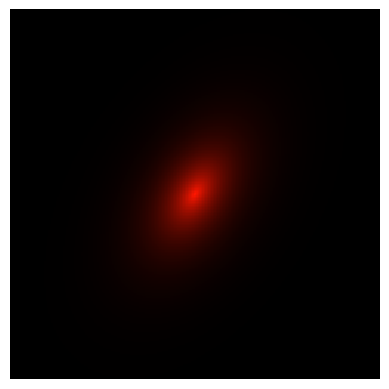

In [5]:
img = galaxy.get_images_flux(
    resolution=resolution,
    stellar_photometry="intrinsic",
    fov=fov,
)

# Make and plot an rgb image
img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
fig, ax, _ = img.plot_rgb_image(show=True)

Similarly to particle images, you can apply PSFs and noise to Parametric images. The process is identical that the method used for particle imaging. For details see the [particle imaging documentation](particle_imaging.ipynb).

## Adding different morphologies together

The galaxy image we created above is very simple, too simple in fact. Real galaxies have different distinct components. To account for this with a parametric galaxy we can create a second galaxy to describe the bulge, since we made a very disky system above. To do so we need to create another fake galaxies with a modified SFZH and morphology, and calculate its spectra and photometry.

In [6]:
# Rename the image
disk_imgs = img

# Define the SFH and metallicity distribution
metal_dist = ZDist.DeltaConstant(metallicity=0.02)
sfh_p = {"peak_age": 200 * Myr, "max_age": 500 * Myr, "tau": 0.5}
sfh = SFH.LogNormal(**sfh_p)  # constant star formation

morph_start = time.time()

# Define the morphology using a simple effective radius and slope
morph = Sersic2D(r_eff=2.5 * kpc, sersic_index=4.0, ellipticity=0, theta=0)

print("Morphology computed, took:", time.time() - morph_start)

# Create the Stars object
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    morphology=morph,
    initial_mass=10**9,
)
print(stars)

galaxy_start = time.time()

# Initialise a parametric Galaxy
bulge = Galaxy(stars, redshift=5)

print("Bulge created, took:", time.time() - galaxy_start)

spectra_start = time.time()

# Generate stellar spectra
bulge_sed = bulge.stars.get_spectra(model)

# Convert to fluxes
bulge.get_observed_spectra(cosmo)

print("Spectra created, took:", time.time() - spectra_start)

phot_start = time.time()

# Generate stellar photometry
bulge.stars.spectra["intrinsic"].get_photo_fnu(filters)

print("Photometry calculated, took:", time.time() - phot_start)

Morphology computed, took: 0.0005033016204833984
+-------------------------------------------------------------------------------------------------------+
|                                                 STARS                                                 |
+--------------------------+----------------------------------------------------------------------------+
| Attribute                | Value                                                                      |
+--------------------------+----------------------------------------------------------------------------+
| sf_hist_func             | <synthesizer.parametric.sf_hist.LogNormal object at 0x7f39b06fb2b0>        |
+--------------------------+----------------------------------------------------------------------------+
| metal_dist_func          | <synthesizer.parametric.metal_dist.DeltaConstant object at 0x7f39b06fbdf0> |
+--------------------------+---------------------------------------------------------------------------

With the bulge created we can make an image of it in isolation, but this time we will use the lower level imaging methods to demonstrate their usage. We can then plot them using the helper method for individual filter images, for more details on this method see the [particle imaging documentation](particle_imaging.ipynb).

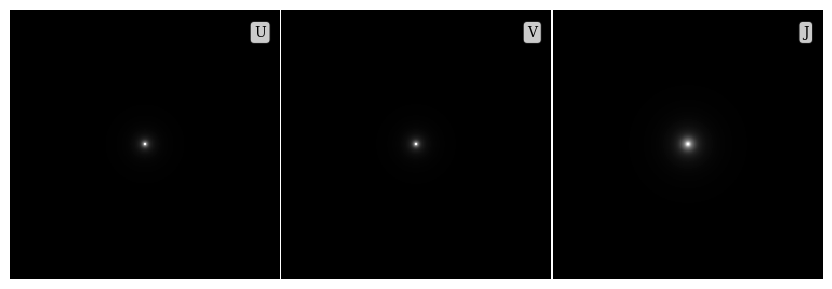

Images took: 0.07341432571411133


In [7]:
img_start = time.time()

# Intialise the Parametric image object
bulge_imgs = ImageCollection(
    resolution=resolution,
    fov=fov,
)

# Compute the photometric images
bulge_imgs.get_imgs_smoothed(
    photometry=bulge.stars.spectra["intrinsic"].photo_fnu,
    density_grid=bulge.stars.morphology.get_density_grid(
        bulge_imgs.resolution,
        bulge_imgs.npix,
    ),
)

# Lets set up a simple normalisation across all images
vmax = 0
for bimg in bulge_imgs.imgs.values():
    up = np.percentile(bimg.arr, 99.9)
    if up > vmax:
        vmax = up

# Get the plot
fig, ax = bulge_imgs.plot_images(
    show=True, vmin=0, vmax=vmax, scaling_func=np.arcsinh
)
plt.close(fig)

print("Images took:", time.time() - img_start)

Now we need to combine the disk and bulge together into a single image. To do this we simply add together the two `ImageCollection` objects. 

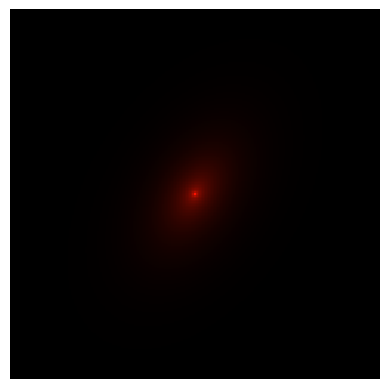

In [8]:
# Combine the images
new_img = disk_imgs + bulge_imgs

# And make a plot
new_img.make_rgb_image(
    rgb_filters={"R": "J", "G": "V", "B": "U"},
)
fig, ax, _ = new_img.plot_rgb_image(show=True)

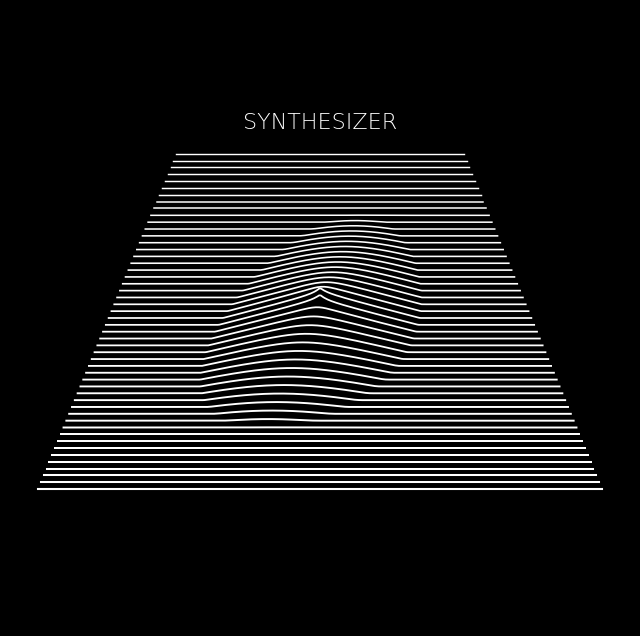

In [9]:
fig, ax = new_img.imgs["U"].plot_unknown_pleasures()
plt.show()